<a href="https://colab.research.google.com/github/luctiz/Grupo43-TP2/blob/master/TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Trabajo Práctico Número 2 - Organización de Datos**
El presente trabajo práctico corresponde a una competencia de Machine Learning, realizada a través de la plataforma Kaggle, en donde se intentará predecir, para cada propiedad, el precio de la misma con la mayor precisión posible.
Para conseguir este objetivo aplicaremos los conocimientos adquiridos a lo largo de la cursada aplicando y probando el resultado de las diversas técnicas de Feature Engineering y combinando el uso de diferentes modelos de Machine Learning.


## Importamos todas las librerías que vamos a necesitar

In [0]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from sklearn.ensemble  import RandomForestRegressor,  VotingRegressor, AdaBoostRegressor
import xgboost as xgb


### Carga de datos

In [0]:
#import io
#ruta = io.StringIO(uploaded['train.csv'].decode('utf-8'))
#ejemplo = pd.read_csv("../content/drive/My Drive/data/ejemploRespuesta.csv", names = ["id", "precio"])
test = pd.read_csv("../content/drive/My Drive/data/test.csv", parse_dates = ['fecha'])
train = pd.read_csv("../content/drive/My Drive/data/train.csv",parse_dates = ['fecha'])
#ejemplo =  pd.read_csv('data/ejemploRespuesta.csv', names = ["id", "precio"] )
#test =  pd.read_csv('data/test.csv', parse_dates = ['fecha'])
#train = pd.read_csv('data/train.csv',parse_dates = ['fecha'])

#### Creo una función para ir viendo la importancia de los features
**(utilizando la importancia de Random Forest)**

In [0]:
# La cantidad que recibe indica la cantidad de features a mostrar, si es negativa muestra los menos importantes,
# y si es positiva muestra los más importantes
rf_model = RandomForestRegressor()
#rf_model.fit(X,Y) #El fit lo hago afuera asi no tengo que fitear nuevamente cada vez que llamo a la funcion(total siempre va a dar lo mismo)
def mostrar_importancias(X, Y,model,cantidad = None):
    rf_model.fit(X,Y)
    importancias = pd.DataFrame(model.feature_importances_,index=X.columns,columns=['importancia']).reset_index()
    importancias.columns = ['feature', 'importancia']
    plt.figure(figsize = (20,5))
    if (cantidad):
        if (cantidad >= 0):
            importancias = importancias.nlargest(cantidad, 'importancia')
        else:
            importancias = importancias.nsmallest(abs(cantidad), 'importancia')
    graf = sns.barplot(x = importancias.feature, y = importancias.importancia, orient = 'v')
    graf.set_ylabel("Importancias", fontsize = 20)
    graf.set_xlabel("Features", fontsize = 20)
    plt.xticks(fontsize = 15, rotation = 'vertical')
    plt.yticks(fontsize = 15)
    if (cantidad):
        if (cantidad >= 0):
            plt.title("Grado de importancia de los "+ str(cantidad)+" Features más importantes", fontsize = 25)
        else:
            plt.title("Grado de importancia de los "+ str(abs(cantidad))+" Features menos importantes", fontsize = 25)
    else:
        plt.title("Grado de importancia de Features totales", fontsize = 25)

# Carga y limpieza de datos

**(Hecho con la info obtenida en el notebook LimpiezaDeDatos)**

In [0]:
#El precio promedio de las publicaciones que no tienen datos de cant de habitaciones esta entre el precio
#promedio de las que tienen 2 y 3 habitaciones
#Entonces voy a asumir que tienen 3 habitaciones, ya que es el valor al cual el precio mas se les asemeja.
train['habitaciones']=train['habitaciones'].fillna(3)
test['habitaciones']=test['habitaciones'].fillna(3)
#Luego convierto a np.int8
train['habitaciones']=train['habitaciones'].astype(np.int8)
test['habitaciones']=test['habitaciones'].astype(np.int8)

In [5]:
train['provincia'].value_counts()/train.provincia.count()

Distrito Federal         0.245117
Edo. de México           0.173475
Jalisco                  0.088549
Querétaro                0.070829
Nuevo León               0.063891
Puebla                   0.043449
San luis Potosí          0.035219
Yucatán                  0.033055
Morelos                  0.030591
Veracruz                 0.024024
Quintana Roo             0.019829
Chihuahua                0.019137
Coahuila                 0.015406
Baja California Norte    0.013425
Sonora                   0.012458
Guanajuato               0.011924
Guerrero                 0.011166
Hidalgo                  0.010511
Michoacán                0.010302
Tamaulipas               0.009602
Durango                  0.009485
Sinaloa                  0.007530
Aguascalientes           0.007309
Baja California Sur      0.007088
Nayarit                  0.005637
Chiapas                  0.004695
Colima                   0.004203
Tabasco                  0.004144
Tlaxcala                 0.003498
Oaxaca        

In [0]:
#A los que tienen null en provincia les asigno la provincia que mas aparece (Distrito federal)
train['provincia']=train['provincia'].fillna('Distrito Federal')
test['provincia']=test['provincia'].fillna('Distrito Federal')
# A los que tienen null en ciudad les asigno la ciudad que más aparece(Querétaro)
train['ciudad']=train['ciudad'].fillna('Querétaro')
test['ciudad']=test['ciudad'].fillna('Querétaro')
#Relleno los nulls en direccion con un - .
train['direccion']=train['direccion'].fillna('-')
test['direccion']=test['direccion'].fillna('-')

#Relleno nulls con el tipodepropiedad que mas aparece, que es 'Casa'
train['tipodepropiedad']=train['tipodepropiedad'].fillna('Casa')
test['tipodepropiedad']=test['tipodepropiedad'].fillna('Casa')

In [0]:
train['metroscubiertos']=train.metroscubiertos.fillna(round(train.metroscubiertos.mean()))
test['metroscubiertos']=test.metroscubiertos.fillna(round(train.metroscubiertos.mean()))
#Luego convierto metroscubiertos a  np.int16
train['metroscubiertos']=train['metroscubiertos'].astype(np.int16)
test['metroscubiertos']=test['metroscubiertos'].astype(np.int16)

In [0]:
#A los nulls los relleno con el promedio de metrostotales de todas las publicaciones en train
train['metrostotales']=train['metrostotales'].fillna(round(train['metrostotales'].mean()))
test['metrostotales']=test['metrostotales'].fillna(round(train['metrostotales'].mean()))
#Luego convierto metrostotales a  np.int16
train['metrostotales']=train['metrostotales'].astype(np.int16)
test['metrostotales']=test['metrostotales'].astype(np.int16)

In [0]:
#A los que no tienen datos de antiguedad los relleno con la antiguedad promedio (es 8)
train['antiguedad']=train['antiguedad'].fillna(round(train['antiguedad'].mean()))
test['antiguedad']=test['antiguedad'].fillna(round(train['antiguedad'].mean()))
#Luego convierto a np.uint8
train['antiguedad']=train['antiguedad'].astype(np.uint8)
test['antiguedad']=test['antiguedad'].astype(np.uint8)

In [0]:
#El precio promedio de los que tienen NULL en garage es parecido al de los que tienen 2.
#Relleno los nulls de esta columna con un 2.
train['garages']=train['garages'].fillna(2)
test['garages']=test['garages'].fillna(2)
#convierto a np.int8
train['garages']=train['garages'].astype(np.int8)
test['garages']=test['garages'].astype(np.int8)

In [0]:
#El precio promedio de los que tienen NULL en banos es mas parecido al de los que tienen 2.
#Relleno los nulls de esta columna con un 2.
train['banos']=train['banos'].fillna(2)
test['banos']=test['banos'].fillna(2)
#convierto a np.int8
train['banos']=train['banos'].astype(np.int8)
test['banos']=test['banos'].astype(np.int8)

In [0]:
train['gimnasio']=train['gimnasio'].astype(np.int8)
train['usosmultiples']=train['usosmultiples'].astype(np.int8)
train['piscina']=train['piscina'].astype(np.int8)
train['escuelascercanas']=train['escuelascercanas'].astype(np.int8)
train['centroscomercialescercanos']=train['centroscomercialescercanos'].astype(np.int8)
test['gimnasio']=test['gimnasio'].astype(np.int8)
test['usosmultiples']=test['usosmultiples'].astype(np.int8)
test['piscina']=test['piscina'].astype(np.int8)
test['escuelascercanas']=test['escuelascercanas'].astype(np.int8)
test['centroscomercialescercanos']=test['centroscomercialescercanos'].astype(np.int8)

In [0]:
train['titulo']=train['titulo'].fillna(' ')
train['descripcion']=train['descripcion'].fillna(' ')
test['titulo']=test['titulo'].fillna(' ')
test['descripcion']=test['descripcion'].fillna(' ')

In [0]:
train['precio']=train['precio'].astype(np.int32)
train['id']=train['id'].astype(np.int32)
test['id']=test['id'].astype(np.int32)

In [0]:
train.lat=train.lat.fillna(train.lat.mean())
train.lng=train.lng.fillna(train.lng.mean())
test.lat=test.lat.fillna(train.lat.mean())
test.lng=test.lng.fillna(train.lng.mean())

In [0]:
#Relleno columnas restantes con un 0 (solo idzona)
train=train.fillna(0)
test=test.fillna(0)

# Armado de features:

In [17]:
train.columns

Index(['id', 'titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'precio'],
      dtype='object')

In [18]:
test.columns

Index(['id', 'titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos'],
      dtype='object')

### Importancias de features numéricos originales

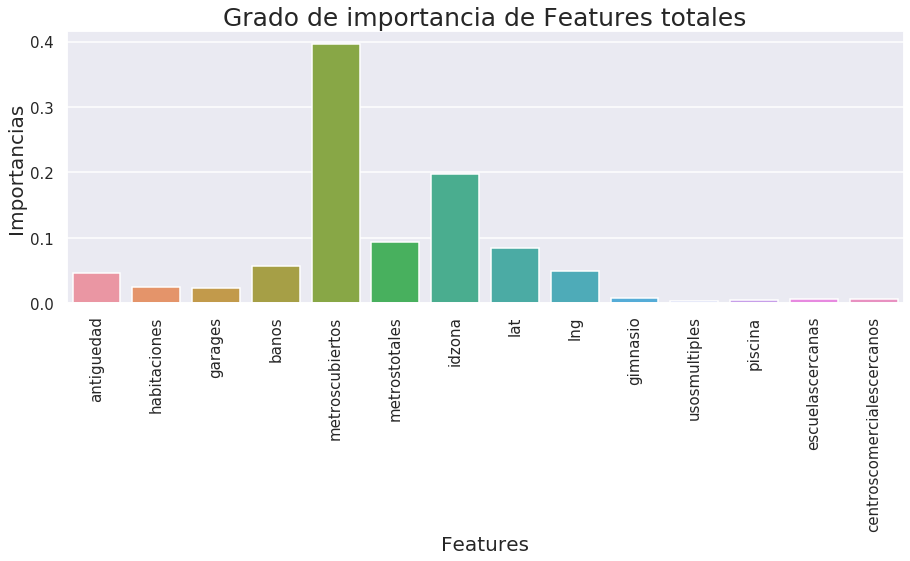

In [46]:
Numericos = ['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng',\
              'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos']
X = train[Numericos]
Y = train['precio']
mostrar_importancias(X, Y, rf_model)

In [47]:
from sklearn.model_selection import cross_val_score
#Pruebo el modelo
scores = cross_val_score(rf_model , X, Y, scoring="neg_mean_absolute_error", cv=2, n_jobs = 4)
RF_mae_score = -scores.mean()
RF_mae_score

733058.9520404637

## Features sobre el tiempo

#### Agrego los días, meses y años para crear features

In [38]:
train['dia'] = train['fecha'].dt.day
train['mes'] = train['fecha'].dt.month
train['año'] = train['fecha'].dt.year
test['dia'] = test['fecha'].dt.day
test['mes'] = test['fecha'].dt.month
test['año'] = test['fecha'].dt.year
train.head()

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,dia,mes,año
0,254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Apartamento,Avenida Division del Norte 2005,Benito Juárez,Distrito Federal,8,2,1,2,80,80,23533.0,20.696818,-99.509221,2015-08-23,0,0,0,0,0,2273000,23,8,2015
1,53461,condominio horizontal en venta,"<p>entre sonora y guerrero, atr&aacute;s del h...",Casa en condominio,AV. MEXICO,La Magdalena Contreras,Distrito Federal,10,3,2,2,268,180,24514.0,19.310205,-99.227655,2013-06-28,0,0,0,1,1,3600000,28,6,2013
2,247984,casa en venta urbi 3 recamaras tonala,descripcion \nla mejor ubicacion residencial e...,Casa,Urbi Tonala,Tonalá,Jalisco,5,3,2,2,144,166,48551.0,20.696818,-99.509221,2015-10-17,0,0,0,0,0,1200000,17,10,2015
3,209067,casa sola en toluca zinacantepec con credito i...,casa en privada con caseta de vigilancia casas...,Casa,IGNACIO MANUEL ALTAMIRANO 128,Zinacantepec,Edo. de México,1,2,1,1,63,67,53666.0,19.301890,-99.688015,2012-03-09,0,0,0,1,1,650000,9,3,2012
4,185997,paseos del sol,bonito departamento en excelentes condiciones ...,Apartamento,PASEOS DEL SOL,Zapopan,Jalisco,10,2,1,1,95,95,47835.0,20.696818,-99.509221,2016-06-07,0,0,0,0,0,1150000,7,6,2016


En el TP1 vimos como los precios iban en aumento a medida que el tiempo aumentaba, por lo que nos interesa crear nuevos features tomando en cuenta el tiempo en el que se publicaron las propiedades.


Para realizar un nuevo feature comenzaremos añadiendo un peso para cada fecha, este peso irá en aumento a medida que las fechas van subiendo, así simularemos el crecimiento del precio a lo largo del tiempo.

Text(0, 0.5, 'Precio')

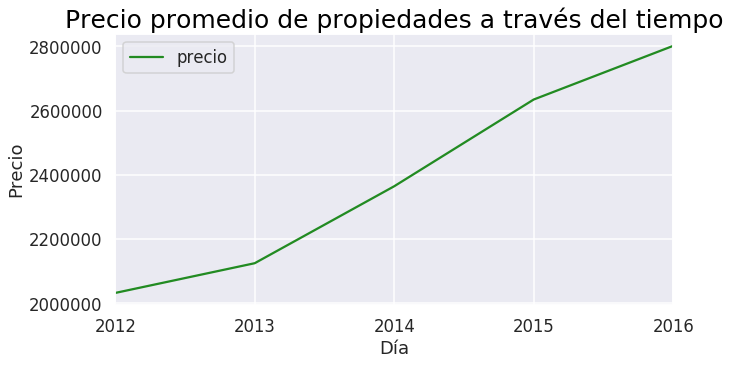

In [39]:
precio_por_anio = train[['año', 'precio']].groupby('año').agg('mean').reset_index()
precio_por_anio
precio_por_anio.plot(x = 'año', y = 'precio', figsize = (10,5), color = 'forestgreen', xticks = [2012,2013,2014,2015,2016])
plt.title("Precio promedio de propiedades a través del tiempo", fontsize=25, color='black')
plt.xlabel('Día', fontsize = 18)
plt.ylabel('Precio', fontsize = 18)


In [0]:
#Califico las fechas de acuerdo a la diferencia entre la fecha actual y la fecha mínima sobre el máximo de dias
fecha_min = train.fecha.min()
fecha_max = train.fecha.max()
delta_max_days = (fecha_max - fecha_min).days
def calificar_fecha(fecha):
    delta = fecha - fecha_min
    return delta.days/delta_max_days

In [41]:
train["puntaje_por_fecha"] = train['fecha'].transform(lambda x: calificar_fecha(x))
train.head(1)

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,dia,mes,año,puntaje_por_fecha
0,254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Apartamento,Avenida Division del Norte 2005,Benito Juárez,Distrito Federal,8,2,1,2,80,80,23533.0,20.696818,-99.509221,2015-08-23,0,0,0,0,0,2273000,23,8,2015,0.728368


In [42]:
#Set de test
test["puntaje_por_fecha"] = test['fecha'].transform(lambda x: calificar_fecha(x))
test.head(1)

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,dia,mes,año,puntaje_por_fecha
0,4941,"casa en venta en miguel hidalgo, distrito federal",<p>excelente casa estilo moderno.</p>,Casa,Bosque de Cedros,Miguel Hidalgo,Distrito Federal,29,3,2,4,300,177,0.0,19.408668,-99.246767,2013-07-20,0,0,0,0,0,20,7,2013,0.309967


### Veo la importancia de los nuevos features

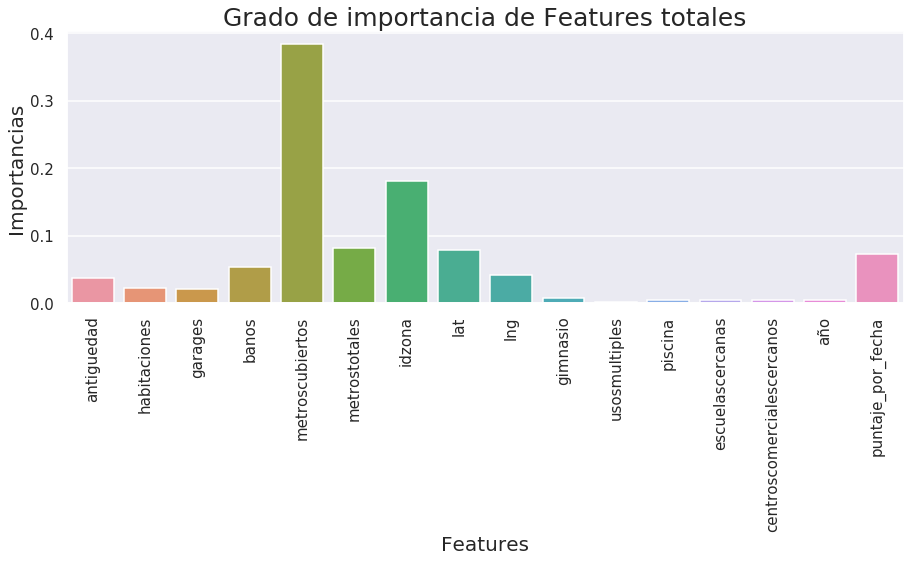

In [43]:
Numericos = ['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng',\
              'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos', 'año', 'puntaje_por_fecha']
X = train[Numericos]
Y = train['precio']
mostrar_importancias(X, Y, rf_model)

In [48]:
#Pruebo el modelo
scores = cross_val_score(rf_model , X, Y, scoring="neg_mean_absolute_error", cv=2, n_jobs = 4)
RF_mae_score = -scores.mean()
RF_mae_score

729954.7294320621

## Features descripcion

Para el primer TP descubrimos que habia ciertas palabras que estaban correlacionadas a mayor precio y otras a menor precio. Usando esa informacion vamos a armar features que nos digan si la descripcion tiene o no determinada palabra

In [0]:
#Paso todas las descripciones a minúscula para contar las palabras con mas precision
train['descripcion']=train['descripcion'].apply(lambda x: x.lower())

In [0]:
Palabras_mayor_precio=['cuarto','vestidor','terraza','family','vista','bodega',\
                       'salón','estudio','jardín','room','jacuzzi','lujo','antecomedor',\
                       'tv','fiestas','juegos','estacionamiento','gimnasio','nado',\
                       'lugares','doble','desayunador','servicio','chimenea','visita',\
                       'acabado','espacio','salon','alberca','garden','spa']
Palabras_menor_precio=['minutos','acept','boiler','reja','credito','transporte'\
                      ,'cochera','contado','escuela','inf','fovissste','cerca',\
                      'bancario','protecciones','patio','infonavit']
Palabras=Palabras_mayor_precio + Palabras_menor_precio

In [0]:
dummies_palabras_descr=pd.DataFrame()
#Por cada palabra en la lista genero una columna que diga si la descripcion contenia esa palabra o no
for palabra in Palabras:
    dummies_palabras_descr[palabra]=train['descripcion'].apply(lambda x: palabra in x).astype(np.int8)
#Renombro estas columnas agregandoles un prefijo
dummies_palabras_descr=dummies_palabras_descr.add_prefix('desc_')

In [53]:
dummies_palabras_descr.head(3)

,desc_cuarto,desc_vestidor,desc_terraza,desc_family,desc_vista,desc_bodega,desc_salón,desc_estudio,desc_jardín,desc_room,desc_jacuzzi,desc_lujo,desc_antecomedor,desc_tv,desc_fiestas,desc_juegos,desc_estacionamiento,desc_gimnasio,desc_nado,desc_lugares,desc_doble,desc_desayunador,desc_servicio,desc_chimenea,desc_visita,desc_acabado,desc_espacio,desc_salon,desc_alberca,desc_garden,desc_spa,desc_minutos,desc_acept,desc_boiler,desc_reja,desc_credito,desc_transporte,desc_cochera,desc_contado,desc_escuela,desc_inf,desc_fovissste,desc_cerca,desc_bancario,desc_protecciones,desc_patio,desc_infonavit
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0


In [0]:
dummies_palabras_descr_test=pd.DataFrame()
#Hago lo mismo para el set de test
for palabra in Palabras:
    dummies_palabras_descr_test[palabra]=test['descripcion'].apply(lambda x: palabra in x).astype(np.int8)
dummies_palabras_descr_test=dummies_palabras_descr_test.add_prefix('desc_')

In [55]:
dummies_palabras_descr_test.head()

,desc_cuarto,desc_vestidor,desc_terraza,desc_family,desc_vista,desc_bodega,desc_salón,desc_estudio,desc_jardín,desc_room,desc_jacuzzi,desc_lujo,desc_antecomedor,desc_tv,desc_fiestas,desc_juegos,desc_estacionamiento,desc_gimnasio,desc_nado,desc_lugares,desc_doble,desc_desayunador,desc_servicio,desc_chimenea,desc_visita,desc_acabado,desc_espacio,desc_salon,desc_alberca,desc_garden,desc_spa,desc_minutos,desc_acept,desc_boiler,desc_reja,desc_credito,desc_transporte,desc_cochera,desc_contado,desc_escuela,desc_inf,desc_fovissste,desc_cerca,desc_bancario,desc_protecciones,desc_patio,desc_infonavit
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


### Veamos las importancias de estos features y su impacto en el modelo

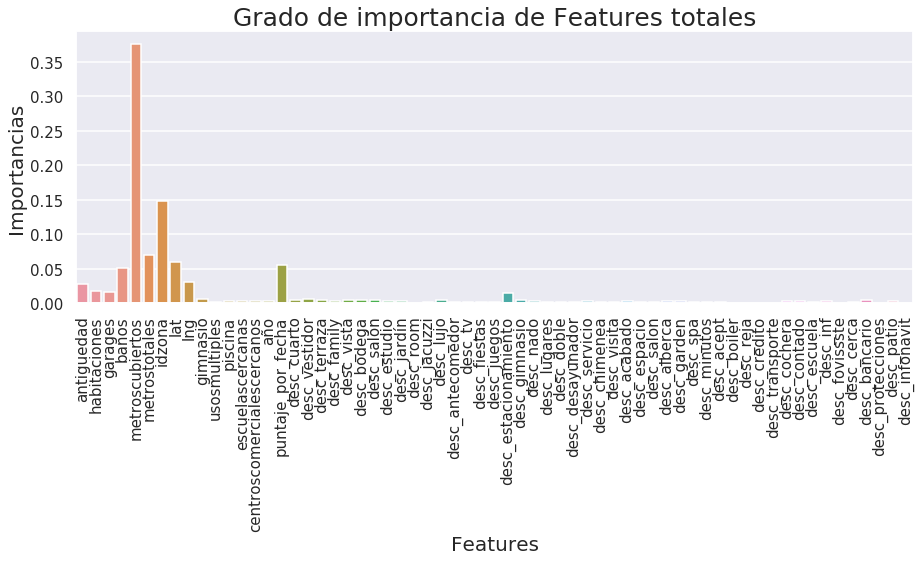

In [56]:
Numericos = ['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng',\
              'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos', 'año', 'puntaje_por_fecha']
X = train[Numericos].join(dummies_palabras_descr)
Y = train['precio']
mostrar_importancias(X, Y, rf_model)

In [57]:
#Pruebo el modelo
scores = cross_val_score(rf_model , X, Y, scoring="neg_mean_absolute_error", cv=2, n_jobs = 4)
RF_mae_score = -scores.mean()
RF_mae_score

700428.2397083377

## Features titulo

Mismo procedimiento anterior pero para palabras que encontramos correlacionadas a mayor o menor precio en 'titulo'

In [0]:
#Paso todas los titulos a minúscula para contar las palabras con mas precision
train['titulo']=train['titulo'].apply(lambda x: x.lower())

In [0]:
Palabras_mayor_precio=['polanco','loma','herradura','condesa','bosque','country',\
                       'hermosa','vista','residencia','condominio','golf','lujo','huixquilucan',\
                      ]
Palabras_menor_precio=['terreno','fracc','casa','villa','remate','recamaras'\
                      ,'ecatepec','cerca','coacalco','izcalli','planta','lote',\
                      'bonita','cautitlan']
Palabras=Palabras_mayor_precio + Palabras_menor_precio

In [0]:
dummies_palabras_titulo=pd.DataFrame()
#Por cada palabra en la lista genero una columna que diga si la descripcion contenia esa palabra o no
for palabra in Palabras:
    dummies_palabras_titulo[palabra]=train['titulo'].apply(lambda x: palabra in x).astype(np.int8)
#Renombro estas columnas agregandoles un prefijo
dummies_palabras_titulo=dummies_palabras_titulo.add_prefix('titl_')

In [62]:
dummies_palabras_titulo.head(3)

,titl_polanco,titl_loma,titl_herradura,titl_condesa,titl_bosque,titl_country,titl_hermosa,titl_vista,titl_residencia,titl_condominio,titl_golf,titl_lujo,titl_huixquilucan,titl_terreno,titl_fracc,titl_casa,titl_villa,titl_remate,titl_recamaras,titl_ecatepec,titl_cerca,titl_coacalco,titl_izcalli,titl_planta,titl_lote,titl_bonita,titl_cautitlan
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0


In [0]:
dummies_palabras_titulo_test=pd.DataFrame()
#Hago lo mismo para el set de test
for palabra in Palabras:
    dummies_palabras_titulo_test[palabra]=test['titulo'].apply(lambda x: palabra in x).astype(np.int8)
dummies_palabras_titulo_test=dummies_palabras_titulo_test.add_prefix('titl_')

In [64]:
dummies_palabras_titulo_test.head(3)

,titl_polanco,titl_loma,titl_herradura,titl_condesa,titl_bosque,titl_country,titl_hermosa,titl_vista,titl_residencia,titl_condominio,titl_golf,titl_lujo,titl_huixquilucan,titl_terreno,titl_fracc,titl_casa,titl_villa,titl_remate,titl_recamaras,titl_ecatepec,titl_cerca,titl_coacalco,titl_izcalli,titl_planta,titl_lote,titl_bonita,titl_cautitlan
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Veamos como se comportan los nuevos features

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


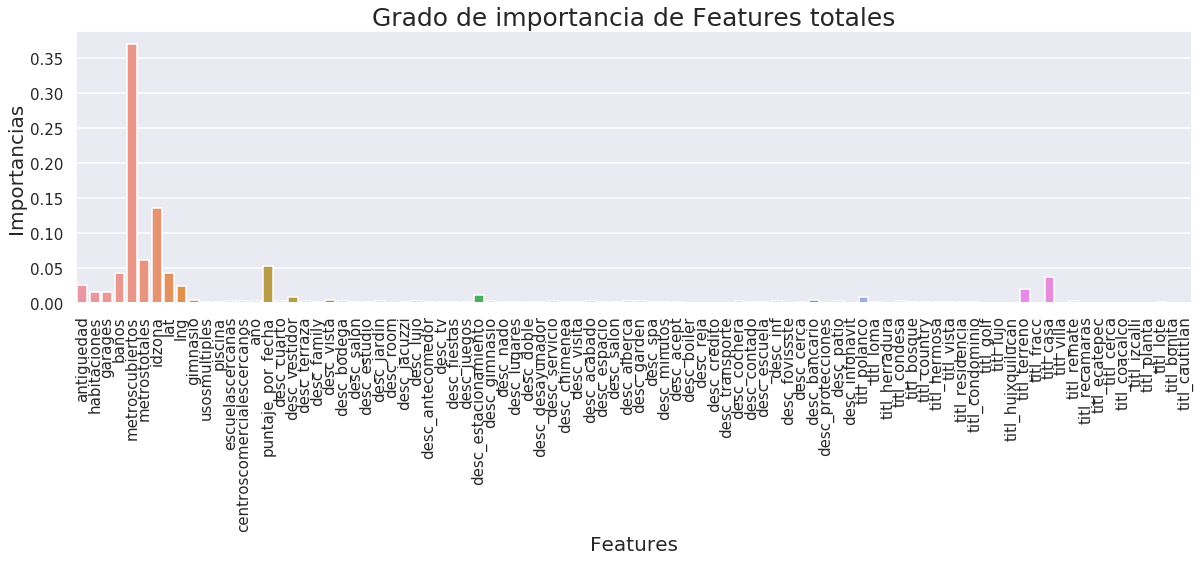

In [65]:
Numericos = ['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng',\
              'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos', 'año', 'puntaje_por_fecha']
X = train[Numericos].join(dummies_palabras_descr).join(dummies_palabras_titulo)
Y = train['precio']
mostrar_importancias(X, Y, rf_model)


In [66]:
#Pruebo el modelo
scores = cross_val_score(rf_model , X, Y, scoring="neg_mean_absolute_error", cv=2, n_jobs = 4)
RF_mae_score = -scores.mean()
RF_mae_score

681119.9041622973

## Agrego features sobre la cantidad de publicaciones

Como hemos visto en el tp1 la cantidad de publicaciones y el precio se comportan igual a través del tiempo, por lo que podríamos estimar el mismo a través de este feature

Text(0.5, 0, 'Año')

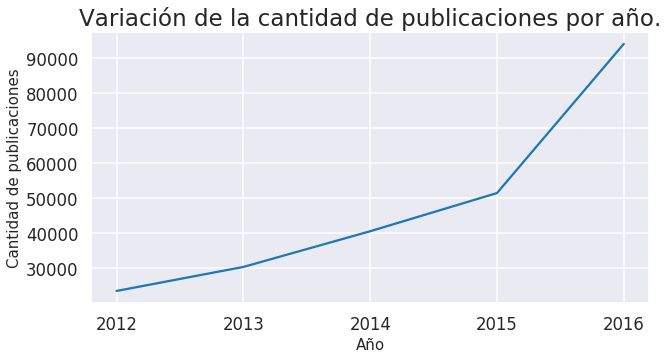

In [67]:
dataXanio = train[['id', 'año']].groupby('año').agg('count').reset_index()
dataXanio.columns = ['año', 'cantidad_publicaciones']
plt.figure(figsize = (10,5))
sns.set_style("darkgrid")
sns.set_context("talk")
pubsXanio = sns.lineplot(data = dataXanio, x = 'año', y = 'cantidad_publicaciones', palette = 'Set1')
pubsXanio.set_xticks([2012, 2013, 2014, 2015, 2016])
pubsXanio.set_title('Variación de la cantidad de publicaciones por año.', fontsize =  23)
pubsXanio.set_ylabel('Cantidad de publicaciones', fontsize = 15)
pubsXanio.set_xlabel('Año', fontsize = 15)

#### Creo Features sobre cantidad de publicaciones por año

In [0]:
#Filtro los nulos con 0 pues si no tengo datos de publicaciones para un día es por que no hubo, es decir, son 0
train['publicaciones_por_año'] = train[['año','id']].groupby(['año']).transform(lambda x: x.count()).fillna(0)
test['publicaciones_por_año'] = test[['año','id']].groupby(['año']).transform(lambda x: x.count()).fillna(0)

## Pruebo target encoder en lugar de oneHotEncoder para tipodepropiedad, ciudades, provincias y agrego idzona

**Primero voy a unificar los dummies sobre palabras**

In [0]:
dummies_palabras=dummies_palabras_descr.join(dummies_palabras_titulo)
dummies_palabras_test=dummies_palabras_descr_test.join(dummies_palabras_titulo_test)

In [70]:
!pip install category_encoders

     |████████████████████████████████| 102kB 2.8MB/s 


### Target: publicaciones_por_año
Voy a usar la cantidad de publicaciones por año como target, pues hemos visto que la cantidad de publicaciones aumentaba en el tiempo, al igual que el precio de las propiedades

In [0]:
import category_encoders as ce
cat_cols = ['tipodepropiedad','ciudad', 'provincia', 'idzona']
target_enc = ce.TargetEncoder(cols = cat_cols)
target_enc.fit(train[cat_cols], train['publicaciones_por_año'])
target_encoder_publicaciones = target_enc.transform(train[cat_cols]).add_suffix('_target_publicaciones')
target_encoder_publicaciones_test = target_enc.transform(test[cat_cols]).add_suffix('_target_publicaciones')

In [72]:
target_encoder_publicaciones.head(2)

,tipodepropiedad_target_publicaciones,ciudad_target_publicaciones,provincia_target_publicaciones,idzona_target_publicaciones
0,61817.687763,62912.989286,58990.523471,64651.204819
1,59753.070115,56328.297113,58990.523471,54434.372093


In [73]:
target_encoder_publicaciones_test.head(2)

,tipodepropiedad_target_publicaciones,ciudad_target_publicaciones,provincia_target_publicaciones,idzona_target_publicaciones
0,60386.053723,58258.681622,58990.523471,54717.419377
1,61817.687763,60371.156102,60825.451816,58905.468031


## **Pruebo con otro target: metroscubiertos**

Como habíamos visto durante el TP1 la cantidad de metros cubiertos y totales estaba relacionada con el precio, ambas se comportaban de manera similar.

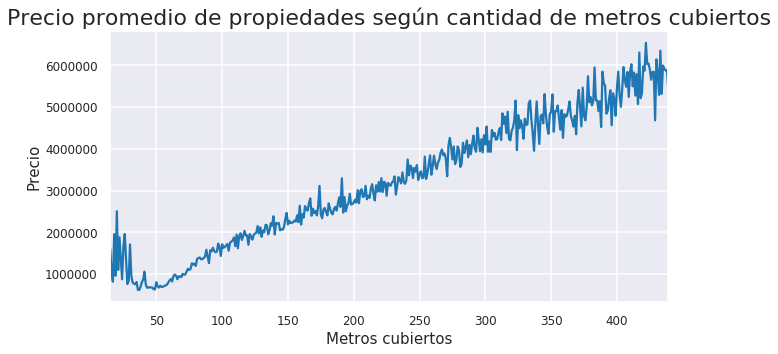

In [74]:
g = train[train['metroscubiertos']>0].groupby('metroscubiertos').mean().plot(kind='line', y='precio', figsize=(10,5), fontsize=12, legend=False)
g.set_title("Precio promedio de propiedades según cantidad de metros cubiertos", fontsize=22)
g.set_xlabel("Metros cubiertos", fontsize=15)
g.set_ylabel("Precio", fontsize=15)
plt.show()


In [0]:
cat_cols = ['tipodepropiedad','ciudad', 'provincia', 'idzona']
target_enc = ce.TargetEncoder(cols = cat_cols)
target_enc.fit(train[cat_cols], train['metroscubiertos'])
target_encoder_metros = target_enc.transform(train[cat_cols]).add_suffix('_target_metros')
target_encoder_metros_test = target_enc.transform(test[cat_cols]).add_suffix('_target_metros')

In [76]:
target_encoder_metros.head(2)

,tipodepropiedad_target_metros,ciudad_target_metros,provincia_target_metros,idzona_target_metros
0,117.866064,128.276829,157.454118,110.795181
1,187.276312,233.158005,157.454118,197.302326


**Como la mejor versióón es contando las publicaciones por año, me quedo con ese feature**

In [0]:
Numericos=['antiguedad','habitaciones','garages','banos','metroscubiertos',\
            'metrostotales','idzona', 'lat', 'lng','gimnasio','usosmultiples','piscina','escuelascercanas',\
            'centroscomercialescercanos', 'año', 'puntaje_por_fecha', 'publicaciones_por_año'] 

## **Importancias**

In [0]:
X = train[Numericos].join(dummies_palabras).join(target_encoder_metros).join(target_encoder_publicaciones)
X_test = test[Numericos].join(dummies_palabras_test).join(target_encoder_metros_test).join(target_encoder_publicaciones_test)
Y = train['precio']

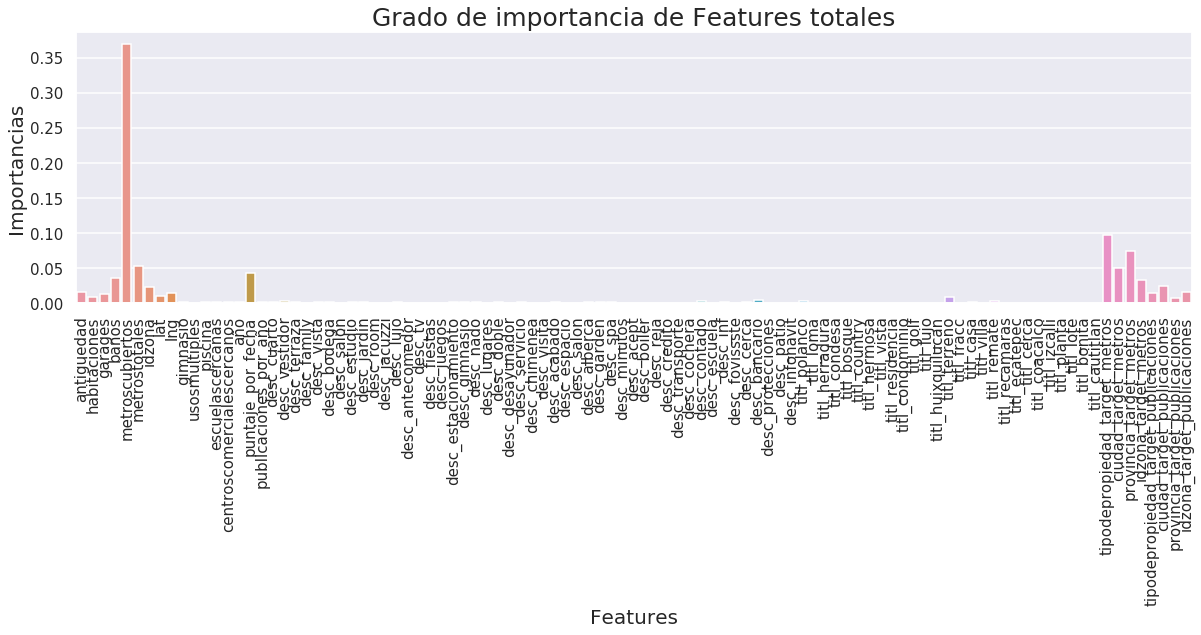

In [79]:
mostrar_importancias(X,Y,rf_model)

###**Veamos los 20 features más importantes**

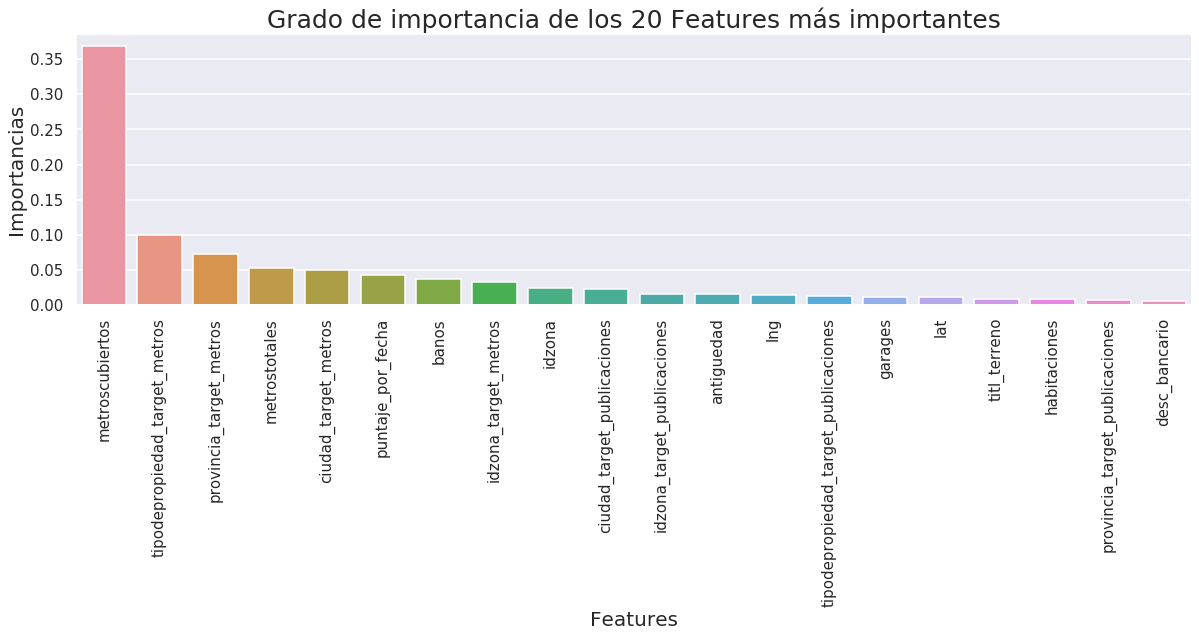

In [81]:
mostrar_importancias(X,Y,rf_model, 20)

In [80]:
#pruebo el modelo
scores = cross_val_score(rf_model , X, Y, scoring="neg_mean_absolute_error", cv=2, n_jobs = 4)
RF_mae_score = -scores.mean()
RF_mae_score

596632.7285459782

# Armado de modelos

In [0]:
def crear_submit(model, x_train, y_train, x_test, nombre):
    model.fit(x_train, y_train)
    result = model.predict(x_test)
    for i in range(len(result)):
      result[i] = round(result[i],-3)
    final = test.loc[:, ['id']]
    final['target'] = result
    #Ruta desde Colab
    ruta = "../content/drive/My Drive/data/submit"+ nombre +".csv"
    #Ruta local
    #ruta = "data/submit_"+ nombre +".csv"
    final.to_csv(ruta,index=False)
    return final

## Voting Regresor

Utilizo Voting Regressor con XGBoost, Random Forest y AdaBoosting como estimadores con los mejores hiper parámetros que he encontrado hasta el momento 

**(ver TP2_Modelos_hiperparametros.ipynb)**

In [0]:
xgb_model = xgb.XGBRegressor(subsample = 0.9, reg_alpha = 1, n_estimators = 200, min_child_weight = 1,\
                             max_features = 43, max_depth = 9, learning_rate = 0.25, gamma = 0.0, \
                             colsample_bytree = 0.9)
rf_model = RandomForestRegressor(random_state = 14, n_estimators = 200, min_samples_split = 5,\
                                 min_samples_leaf = 2, max_features = 51, max_depth = 40, oob_score= True)
abr_model = AdaBoostRegressor(base_estimator=xgb_model, random_state = 22, n_estimators = 11, loss = 'linear', learning_rate = 0.4)
vr_model = VotingRegressor(estimators = [('XGBoost', xgb_model), ('RandomForest', rf_model), ('AdaBoost', abr_model)], weights = [2,1,3])

In [0]:
scores = cross_val_score(vr_model , X, Y, scoring="neg_mean_absolute_error", cv=2, n_jobs = 4)
RF_mae_score = -scores.mean()
RF_mae_score

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:47:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:52:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:55:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:57:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:00:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:02:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:04:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:07:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:17:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:23:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:26:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:28:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:33:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:38:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

512217.29283014557

## Grafico de importancias

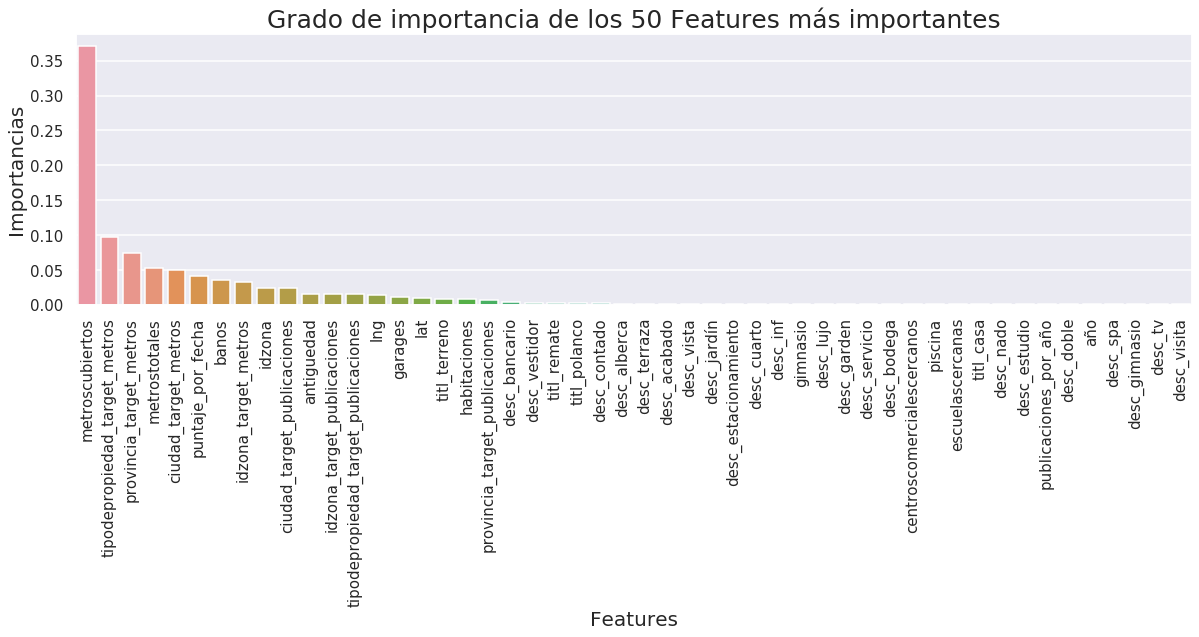

In [82]:
#Muestro los 50 mas importantes
mostrar_importancias(X,Y,rf_model, 50)

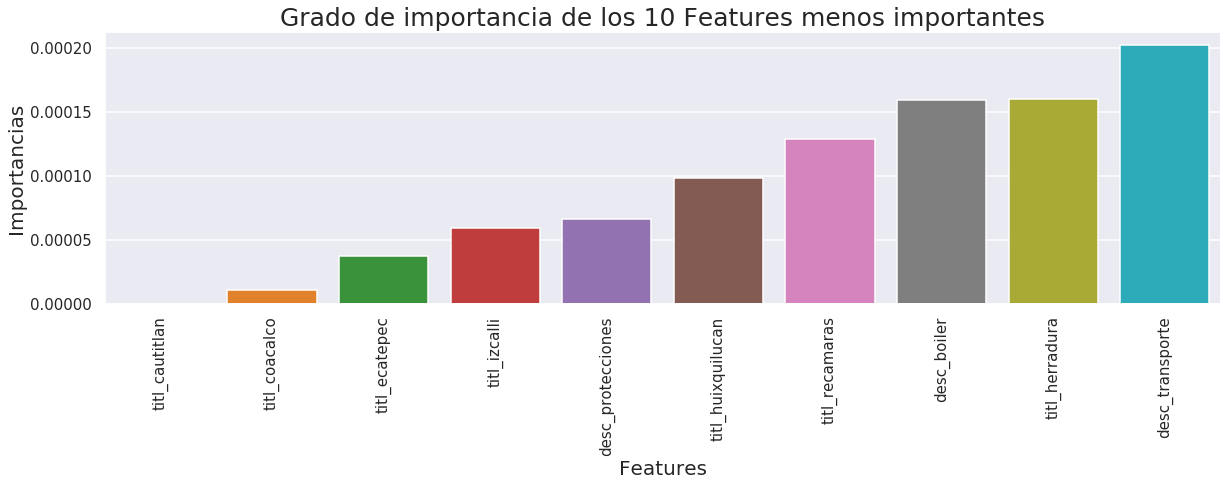

In [83]:
#Muestro los 10 menos importantes
mostrar_importancias(X,Y,rf_model, -10)

## Nuevos Features
**Como vimos entre los features más importante se encuentra la cantidad de baños por lo que crearemos features tomando en cuenta este atributo**

In [0]:
cat_cols = ['tipodepropiedad','ciudad', 'provincia', 'idzona']
target_enc = ce.TargetEncoder(cols = cat_cols)
target_enc.fit(train[cat_cols], train['banos'])
target_encoder_banos = target_enc.transform(train[cat_cols]).add_suffix('_target_banos')
target_encoder_banos_test = target_enc.transform(test[cat_cols]).add_suffix('_target_banos')

In [85]:
target_encoder_banos.head()

,tipodepropiedad_target_banos,ciudad_target_banos,provincia_target_banos,idzona_target_banos
0,1.821088,1.922099,1.988345,1.871486
1,2.350832,2.438320,1.988345,2.162791
2,2.225771,1.703657,2.196911,1.842105
3,2.225771,1.935065,2.073305,1.937500
4,1.821088,2.320174,2.196911,1.959302


#### Agrego features tomando en cuenta los metros totales

In [0]:
cat_cols = ['tipodepropiedad','ciudad', 'provincia', 'idzona']
target_enc = ce.TargetEncoder(cols = cat_cols)
target_enc.fit(train[cat_cols], train['metrostotales'])
target_encoder_metros_tot = target_enc.transform(train[cat_cols]).add_suffix('_target_metros_tot')
target_encoder_metros_tot_test = target_enc.transform(test[cat_cols]).add_suffix('_target_metros_tot')

In [87]:
target_encoder_metros_tot_test.head()

,tipodepropiedad_target_metros_tot,ciudad_target_metros_tot,provincia_target_metros_tot,idzona_target_metros_tot
0,182.980072,162.858499,167.047604,184.442787
1,146.755690,239.065345,239.146443,256.636829
2,146.755690,170.360098,167.047604,143.493151
3,146.755690,172.839853,172.860717,149.588238
4,182.980072,118.508260,174.116543,74.950001


#### También puedo tomar en cuenta la antiguedad de las propiedades

In [0]:
cat_cols = ['tipodepropiedad','ciudad', 'provincia', 'idzona']
target_enc = ce.TargetEncoder(cols = cat_cols)
target_enc.fit(train[cat_cols], train['antiguedad'])
target_encoder_antiguedad = target_enc.transform(train[cat_cols]).add_suffix('_target_antiguedad')
target_encoder_antiguedad_test = target_enc.transform(test[cat_cols]).add_suffix('_target_antiguedad')

In [89]:
target_encoder_antiguedad

,tipodepropiedad_target_antiguedad,ciudad_target_antiguedad,provincia_target_antiguedad,idzona_target_antiguedad
0,8.304878,10.185128,11.678378,9.188755
1,6.589418,11.720735,11.678378,9.279070
2,8.228656,5.711223,6.847726,4.263158
3,8.228656,4.558442,9.828755,1.750002
4,8.304878,6.213900,6.847726,10.465116
...,...,...,...,...
239995,8.228656,4.558442,9.828755,1.750002
239996,8.228656,6.347976,9.828755,5.083333
239997,8.304878,10.185128,11.678378,10.695549
239998,8.228656,13.915293,11.678378,19.970564


#### Por último considero la cantidad de habitaciones

In [0]:
cat_cols = ['tipodepropiedad','ciudad', 'provincia', 'idzona']
target_enc = ce.TargetEncoder(cols = cat_cols)
target_enc.fit(train[cat_cols], train['habitaciones'])
target_encoder_hab = target_enc.transform(train[cat_cols]).add_suffix('_target_hab')
target_encoder_hab_test = target_enc.transform(test[cat_cols]).add_suffix('_target_hab')

In [91]:
target_encoder_hab_test.head()

,tipodepropiedad_target_hab,ciudad_target_hab,provincia_target_hab,idzona_target_hab
0,3.089875,2.516480,2.762694,2.921491
1,2.397168,2.935353,2.937437,2.943734
2,2.397168,3.031740,2.762694,2.602740
3,2.397168,2.828036,2.827857,2.117647
4,3.089875,2.807580,2.973562,2.550000


#### Veamos si estos features se encuentran entre los más importantes y probemos el modelo

In [0]:
X = train[Numericos].join(dummies_palabras).join(target_encoder_metros).join(target_encoder_publicaciones).join(target_encoder_banos).join(target_encoder_metros_tot).join(target_encoder_antiguedad).join(target_encoder_hab)
X_test = test[Numericos].join(dummies_palabras_test).join(target_encoder_metros_test).join(target_encoder_publicaciones_test).join(target_encoder_banos_test).join(target_encoder_metros_tot_test).join(target_encoder_antiguedad_test).join(target_encoder_hab_test)
Y = train['precio']

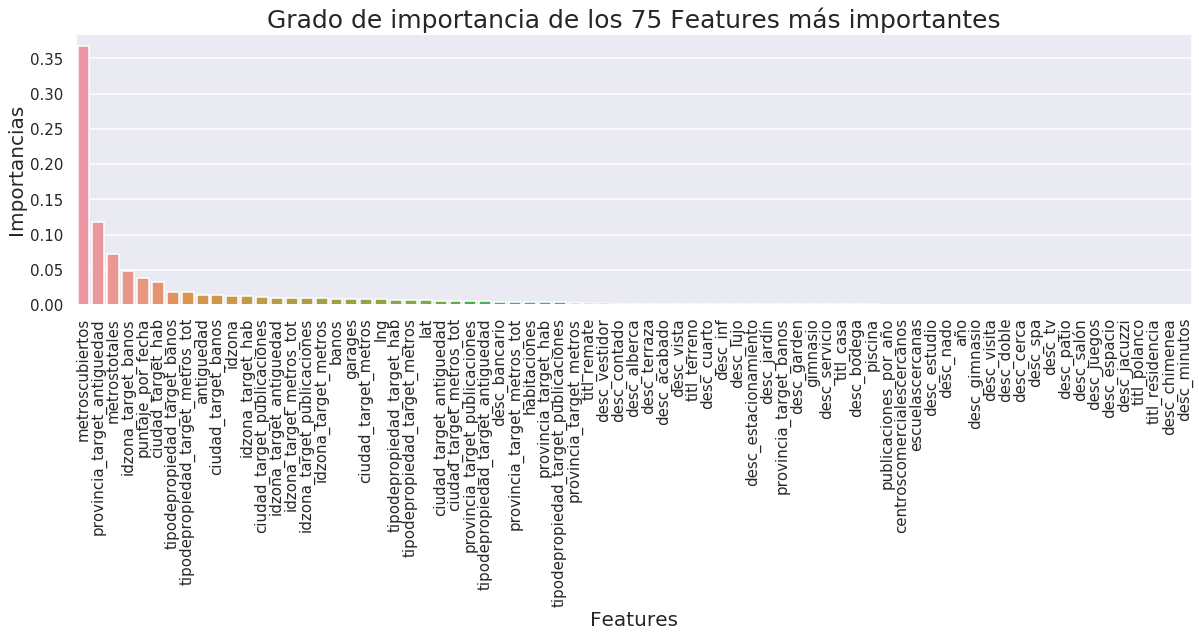

In [93]:
mostrar_importancias(X,Y,rf_model,75)

Podemos observar como varios de nuestros nuevos features aparecen entre los más importantes

In [0]:
#Pruebo el modelo
scores = cross_val_score(vr_model , X, Y, scoring="neg_mean_absolute_error", cv=2)
RF_mae_score2 = -scores.mean()
RF_mae_score2

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:50:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:59:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:02:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:06:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:09:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:13:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:17:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:20:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:39:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:49:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:52:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:56:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:00:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:03:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:07:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:11:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

495208.5242124712

In [0]:
scores

array([-493604.15328616, -496812.89513878])

In [0]:
#Mejor  versión hasta el momento( 478525.98270 en Kaggle)
X = train[Numericos].join(dummies_palabras).join(target_encoder_metros).join(target_encoder_publicaciones).join(target_encoder_banos).join(target_encoder_metros_tot).join(target_encoder_antiguedad).join(target_encoder_hab)
X_test = test[Numericos].join(dummies_palabras_test).join(target_encoder_metros_test).join(target_encoder_publicaciones_test).join(target_encoder_banos_test).join(target_encoder_metros_tot_test).join(target_encoder_antiguedad_test).join(target_encoder_hab_test)
Y = train['precio']

In [0]:
X.head()

,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,año,puntaje_por_fecha,publicaciones_por_año,desc_cuarto,desc_vestidor,desc_terraza,desc_family,desc_vista,desc_bodega,desc_salón,desc_estudio,desc_jardín,desc_room,desc_jacuzzi,desc_lujo,desc_antecomedor,desc_tv,desc_fiestas,desc_juegos,desc_estacionamiento,desc_gimnasio,desc_nado,desc_lugares,desc_doble,desc_desayunador,desc_servicio,...,titl_lujo,titl_huixquilucan,titl_terreno,titl_fracc,titl_casa,titl_villa,titl_remate,titl_recamaras,titl_ecatepec,titl_cerca,titl_coacalco,titl_izcalli,titl_planta,titl_lote,titl_bonita,titl_cautitlan,tipodepropiedad_target_metros,ciudad_target_metros,provincia_target_metros,idzona_target_metros,tipodepropiedad_target_publicaciones,ciudad_target_publicaciones,provincia_target_publicaciones,idzona_target_publicaciones,tipodepropiedad_target_banos,ciudad_target_banos,provincia_target_banos,idzona_target_banos,tipodepropiedad_target_metros_tot,ciudad_target_metros_tot,provincia_target_metros_tot,idzona_target_metros_tot,tipodepropiedad_target_antiguedad,ciudad_target_antiguedad,provincia_target_antiguedad,idzona_target_antiguedad,tipodepropiedad_target_hab,ciudad_target_hab,provincia_target_hab,idzona_target_hab
0,8,2,1,2,80,80,23533.0,20.696818,-99.509221,0,0,0,0,0,2015,0.728368,51470,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,117.866064,128.276829,157.454118,110.795181,61817.687763,62912.989286,58990.523471,64651.204819,1.821088,1.922099,1.988345,1.871486,146.755690,153.438442,167.047604,147.445783,8.304878,10.185128,11.678378,9.188755,2.397168,2.566279,2.762694,2.453815
1,10,3,2,2,268,180,24514.0,19.310205,-99.227655,0,0,0,1,1,2013,0.297919,30386,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,187.276312,233.158005,157.454118,197.302326,59753.070115,56328.297113,58990.523471,54434.372093,2.350832,2.438320,1.988345,2.162791,170.538426,209.363780,167.047604,203.860465,6.589418,11.720735,11.678378,9.279070,2.957610,3.035171,2.762694,2.848837
2,5,3,2,2,144,166,48551.0,20.696818,-99.509221,0,0,0,0,0,2015,0.758488,51470,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,193.095321,109.123581,171.952962,104.657895,60386.053723,65943.460277,69072.906771,60646.947368,2.225771,1.703657,2.196911,1.842105,182.980072,113.412358,165.619644,123.315789,8.228656,5.711223,6.847726,4.263158,3.089875,2.767970,3.028534,2.894737
3,1,2,1,1,63,67,53666.0,19.301890,-99.688015,0,0,0,1,1,2012,0.037240,23534,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,193.095321,163.220779,179.409571,144.000009,60386.053723,59544.324675,59400.198092,56323.751399,2.225771,1.935065,2.073305,1.937500,182.980072,172.811688,174.116543,157.312506,8.228656,4.558442,9.828755,1.750002,3.089875,2.772727,2.973562,2.687500
4,10,2,1,1,95,95,47835.0,20.696818,-99.509221,0,0,0,0,0,2016,0.886637,94038,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,117.866064,181.446911,171.952962,147.122093,61817.687763,69682.227799,69072.906771,71151.313953,1.821088,2.320174,2.196911,1.959302,146.755690,170.897104,165.619644,141.139535,8.304878,6.213900,6.847726,10.465116,2.397168,3.013900,3.028534,2.779070


### Guardo los features para entrenar los modelos

In [0]:
#me voy a guardar los features para poder tunear los modelos e hiper parámetros
X.to_csv("../content/drive/My Drive/data/features_train.csv", index = False)
X_test.to_csv("../content/drive/My Drive/data/features_test.csv", index = False)

# Creo submit

In [0]:
submit1 = crear_submit(vr_model,X, Y, X_test, "_features_habitaciones")
submit1.head()

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[18:34:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:52:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:59:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:06:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:13:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:21:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

,id,target
0,4941,6374000.0
1,51775,1081000.0
2,115253,2037000.0
3,299321,1341000.0
4,173570,638000.0
